### Dataset Loading and Libraries Import
In this section dataset is loaded from github repository. \
It consists of 2 folders (Training, Testing), which are divided into categories in turn.

In [47]:
!pip install -U segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.5 MB/s eta 0:00:00a 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 KB 47.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=51174fce5cb0b44462576b5d22de22855306e6987337e0dadc47c6c6ddb63ded
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60967 sha256=ce2897da1dc454a44d1178a0f3fa41fb177d94298c2dcc61711eb5df4557ee90
  Stored in directory: /root/.cac

In [13]:
!mkdir DataSet
!cd Dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

/usr/bin/sh: 1: cd: can't cd to Dataset
fatal: destination path 'Brain-Tumor-Classification-DataSet' already exists and is not an empty directory.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

import imutils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, datasets, transforms

import segmentation_models_pytorch as smp

from tqdm import tqdm

import ipywidgets as widgets
import io
import os

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

### Data Visualization
In this section training images are loaded and visualized by category.

In [7]:
folder_train_path = 'DataSet/Brain-Tumor-Classification-DataSet/Training'
folder_test_path = 'DataSet/Brain-Tumor-Classification-DataSet/Testing'

Categories = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [219]:
def load_images(folder_path):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    images = []
    path = os.listdir(folder_path)
    path.sort()
    for filename in path:
        img = Image.open(os.path.join(folder_path, filename)).convert('RGB')
        image = transform(img)
        images.append(image)
    return images

def flatten(x):
  return [el for el_set in x for el in el_set]

In [220]:
train_set, test_set, train_label_set, test_label_set = [], [], [], []

for category in Categories:
    train_path = os.path.join(folder_train_path, category)
    test_path = os.path.join(folder_test_path, category)
    
    train_data = load_images(train_path)
    test_data = load_images(test_path)
    
    train_set.append(train_data)
    test_set.append(test_data)
    train_label_set.append(np.full(len(train_data), category))
    test_label_set.append(np.full(len(test_data), category))

In [221]:
train_data = flatten(train_set)
train_labels = np.array(flatten(train_label_set))
test_data = flatten(test_set)
test_labels = np.array(flatten(test_label_set))

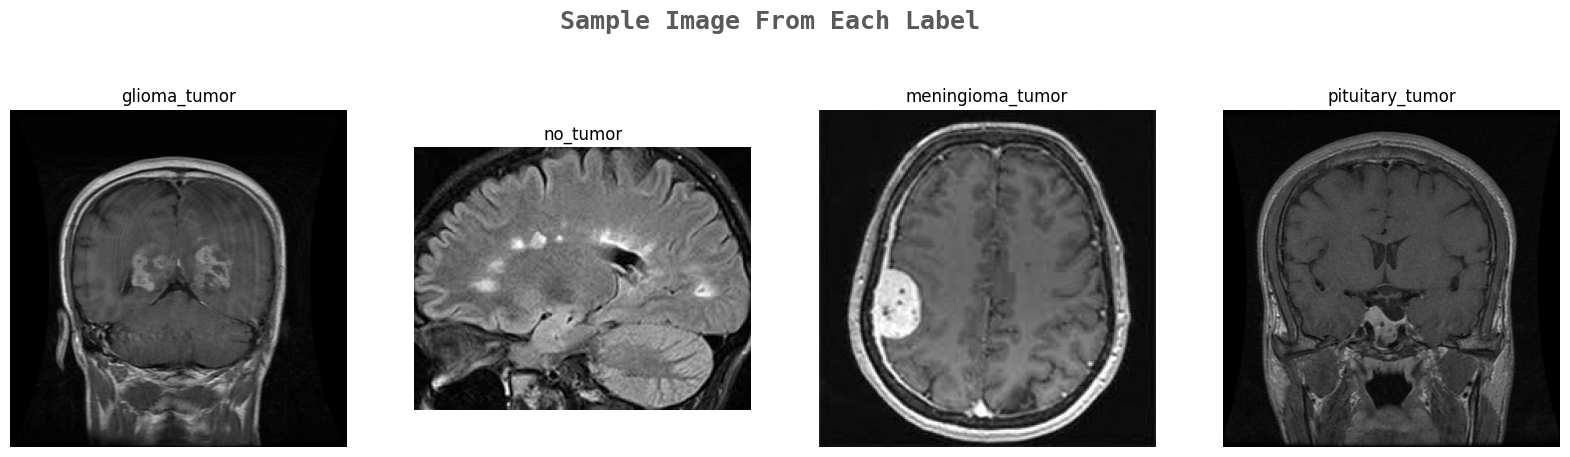

In [222]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for cat in Categories:
    j=9
    ind = np.random.choice(np.where(train_labels == cat)[0])
    img = train_data[ind]
    ax[k].imshow(img.permute(1,2,0))
    ax[k].set_title(cat)
    ax[k].axis('off')
    k+=1

### Setting Transformers
In this section we initialize train and test transformers.

In [223]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # New: Affine transformations
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.05, p=0.5),  # New: Random perspective transformation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

### Data Preprocessing and Splitting
In this section the goal is to apply transformations for initial images to increase their quality in terms of training a deep learning algorithm. \
After that, train/test/validation dataloader is created.

In [11]:
train_data_path = 'DataSet/Brain-Tumor-Classification-DataSet/Training'
test_data_path = 'DataSet/Brain-Tumor-Classification-DataSet/Testing'

train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transforms)

train_size = int(0.8 * len(train_dataset))  # 80% of data for training
val_size = len(train_dataset) - train_size  # 20% for validation
train, val = random_split(train_dataset, [train_size, val_size])

batch_size = 32 

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Setting a Device

In [224]:
device = "cuda"

### Creating Segmentation Mask
In this section pretrained segmentation model is used to create a mask on the current dataset.

In [13]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

aux_params = dict(
    pooling='avg',
    dropout=0.3,
    activation=ACTIVATION,
    classes=1,
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

In [14]:
model_name = 'DeepLabV3+'#'Unet++'
model = smp.DeepLabV3Plus(**common_params) #smp.UnetPlusPlus(**common_params)
weight_path = f'../Segmentation/{model_name}_best-3.pth'
model.load_state_dict(torch.load(weight_path, map_location=device), strict=False)
model = model.to(device)
model.eval()

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStatic

In [225]:
def plot_pair(image,mask):
    """
    Inputs: image and mask
    Outputs: plot both image and plot side by side
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
    axes[0].imshow(image)
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].imshow(mask)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    fig.tight_layout()


def overlay_mask_on_image(image, mask, alpha=0.4):
    mask_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    final_img = cv2.addWeighted(mask_bgr, alpha, image, 1-alpha, 0)
    return final_img

In [226]:
def estimate_mask(input_image, device):
    input_image = input_image.unsqueeze(0).to(device)  # Add batch dimension and send to device
    
    model.eval()
    with torch.no_grad():
        output = model(input_image)
        if isinstance(output, tuple):
            output = output[0]
        prediction = torch.sigmoid(output)
        predicted_mask = (prediction > 0.55).float()
    return predicted_mask

In [227]:
X_train_mask, X_test_mask = [], []
for img in train_data:
    img = transforms.Resize(size=(512,512))(img)
    mask = estimate_mask(img, device)[0]
    mask_ = mask.cpu().permute(1,2,0).numpy()
    img_ = img.permute(1,2,0).numpy()
    
    new_img = overlay_mask_on_image(img_, mask_)
    X_train_mask.append(new_img)

for img in test_data:
    img = transforms.Resize(size=(512,512))(img)
    mask = estimate_mask(img, device)[0]
    mask_ = mask.cpu().permute(1,2,0).numpy()
    img_ = img.permute(1,2,0).numpy()
    
    new_img = overlay_mask_on_image(img_, mask_)
    X_test_mask.append(new_img)

In [228]:
X_train_mask_transformed, X_test_mask_transformed = [], []
for img in X_train_mask:
    pil_img = transforms.ToPILImage()(img)
    X_train_mask_transformed.append(train_transforms(pil_img))

for img in X_test_mask:
    pil_img = transforms.ToPILImage()(img)
    X_test_mask_transformed.append(test_transforms(pil_img))

meningioma_tumor


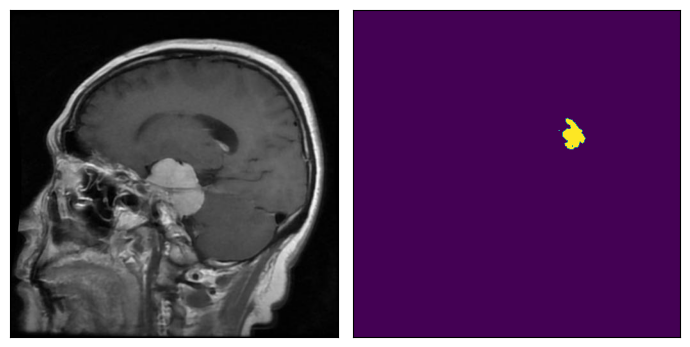

In [258]:
idx = 2004
print(train_labels[idx])
img = train_data[idx]
mask = estimate_mask(img, device)[0]
plot_pair(img.permute(1,2,0), mask.cpu().permute(1,2,0).numpy())

glioma_tumor


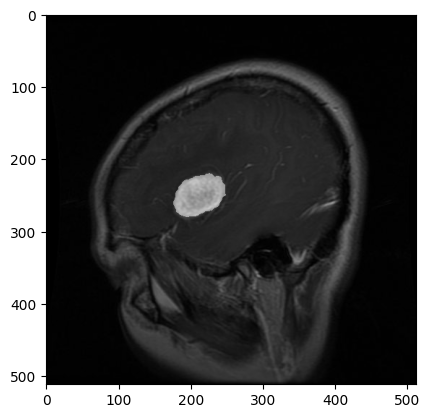

In [259]:
idx = 5
print(train_labels[idx])
plt.imshow(X_train_mask[idx]);

In [229]:
enc = LabelEncoder()
y = enc.fit_transform(Categories)
y_train = enc.transform(train_labels)
y_test = enc.transform(test_labels)

### Masked Data Preprocessing and Splitting
In this section the goal is to apply transformations for masked images to increase their quality in terms of training a deep learning algorithm. \
After that, train/test/validation dataloader is created.

In [230]:
class Dataset():
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32

train_dataset = Dataset(X_train_mask_transformed, y_train)
test_dataset = Dataset(X_test_mask_transformed, y_test)

train_size = int(0.8 * len(train_dataset))  # 80% of data for training
val_size = len(train_dataset) - train_size  # 20% for validation
train, val = random_split(train_dataset, [train_size, val_size])

masked_train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0)
masked_val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=0)
masked_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Training Deep Learning Models
In this section training and testing epochs are created with early stopping criteria. The best model is saved into "best_model.pth". \
The best performance `resnet34` shows.

In [231]:
def epoch_train(data_loader, clf, criterion, opt, device):
    train_acc, running_loss = 0, 0
    clf.train(True)
    for i, data in enumerate(data_loader, 1):
        model_input, target = data[0].to(device), data[1].to(device)
        opt.zero_grad()
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        loss.backward()
        opt.step()

        prediction = model_output.argmax(dim=-1, keepdim=True)
        train_acc += prediction.eq(target.view_as(prediction)).sum().item()
        running_loss += loss.item()
    return running_loss / i, train_acc / len(data_loader.dataset)

def epoch_test(data_loader, clf, criterion, device):
    running_loss, test_acc = 0.0, 0.0
    clf.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader, 1):
            model_input, target = data[0].to(device), data[1].to(device)
            model_output = clf(model_input)
            loss = criterion(model_output, target)

            prediction = model_output.argmax(dim=-1, keepdim=True)
            test_acc += prediction.eq(target.view_as(prediction)).sum().item()
            running_loss += loss.item()
    return running_loss / i, test_acc / len(data_loader.dataset)

In [262]:
def train_model(train_loader, val_loader, clf, criterion, opt, scheduler, device, n_epochs=15):
    best_val_loss = float('inf')
    patience = 7  # Number of epochs to wait after last time validation loss improved.
    trigger_times = 0  # Count how many times the validation loss didn't improve.

    for epoch in range(n_epochs):  # Modified line: tqdm removed
        print(f"Epoch {epoch+1}/{n_epochs}")  # Added line: Manual epoch tracking

        # Training phase
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt, device)

        # Validation phase
        val_loss, val_acc = epoch_test(val_loader, clf, criterion, device)

        # Early stopping logic
        if val_loss < best_val_loss:
            print(f"Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}). Saving the model!")
            best_val_loss = val_loss
            trigger_times = 0
            # Save the model if validation loss decreases
            # torch.save(clf.state_dict(), 'best_model.pth')  # Save your model parameters or state_dict
        else:
            trigger_times += 1
            print(f"Validation loss did not improve this epoch. ({trigger_times}/{patience})")

        if trigger_times >= patience:
            print("Early stopping!")
            break  # Early stopping

        print(f'[Epoch {epoch + 1}/{n_epochs}] Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}, ' +
              f'Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}')

        # Update the learning rate
        scheduler.step(val_loss)

#### ResNet34
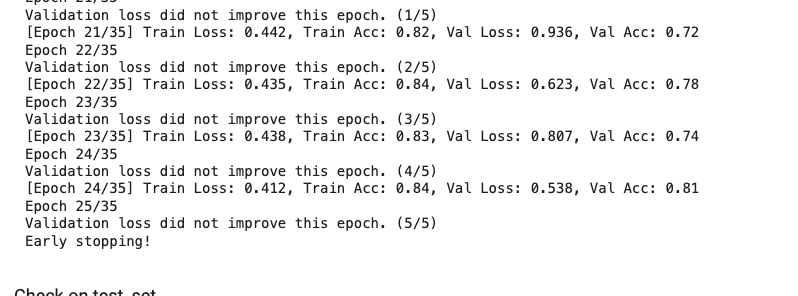

In [26]:
clf = models.resnet34(weights=None)
clf = clf.cuda() if torch.cuda.is_available() else clf
opt = torch.optim.SGD(clf.parameters(), lr=0.008, momentum=0.7, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

`lr=0.01` overfitting \
`lr=0.001` too long \
`momentum=0.9` too much

Try pretrained model
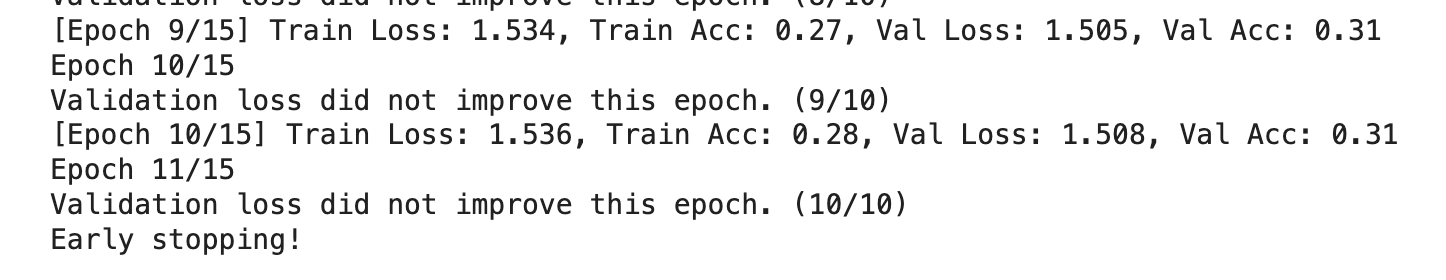

In [ ]:
# Load the pretrained ResNet34 model
clf = models.resnet34()

# Replace the final layer with a new one (adjust according to your dataset)
num_ftrs = clf.fc.in_features
clf.fc = nn.Linear(num_ftrs, 4)  # Assuming 4 classes for brain tumor classification

clf = clf.cuda() if torch.cuda.is_available() else clf

#### ResNet50
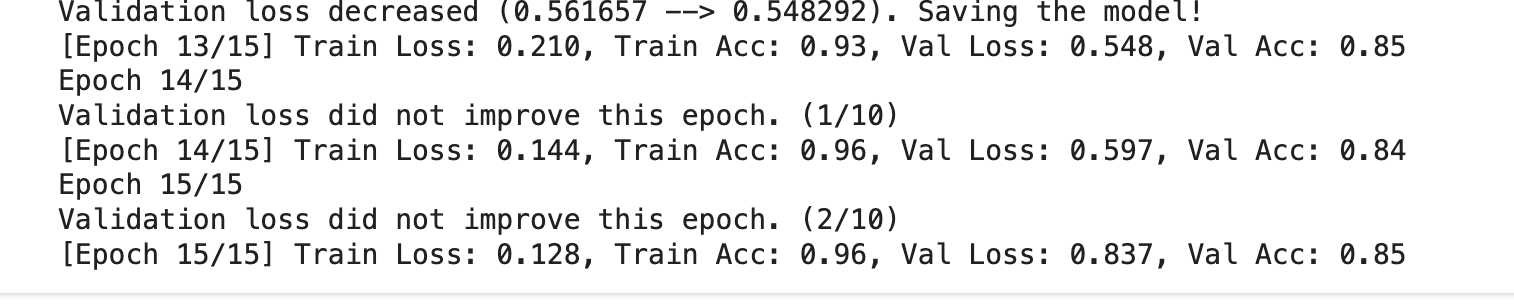

In [31]:
clf = models.resnet50(weights=None)
clf = clf.cuda() if torch.cuda.is_available() else clf
opt = torch.optim.SGD(clf.parameters(), lr=0.008, momentum=0.7, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

#### ResNet18
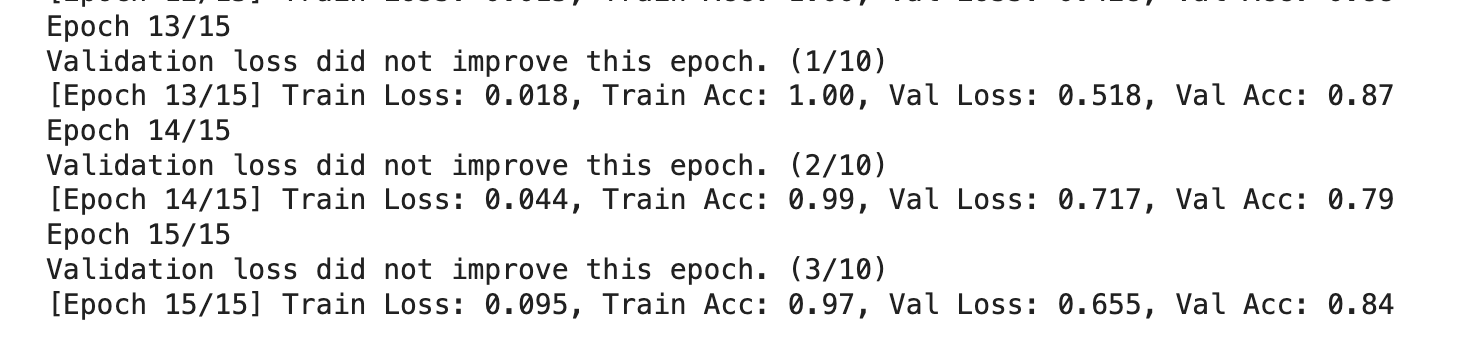

In [38]:
clf = models.resnet18(weights=None)
clf = clf.cuda() if torch.cuda.is_available() else clf
opt = torch.optim.SGD(clf.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

#### EfficientNet
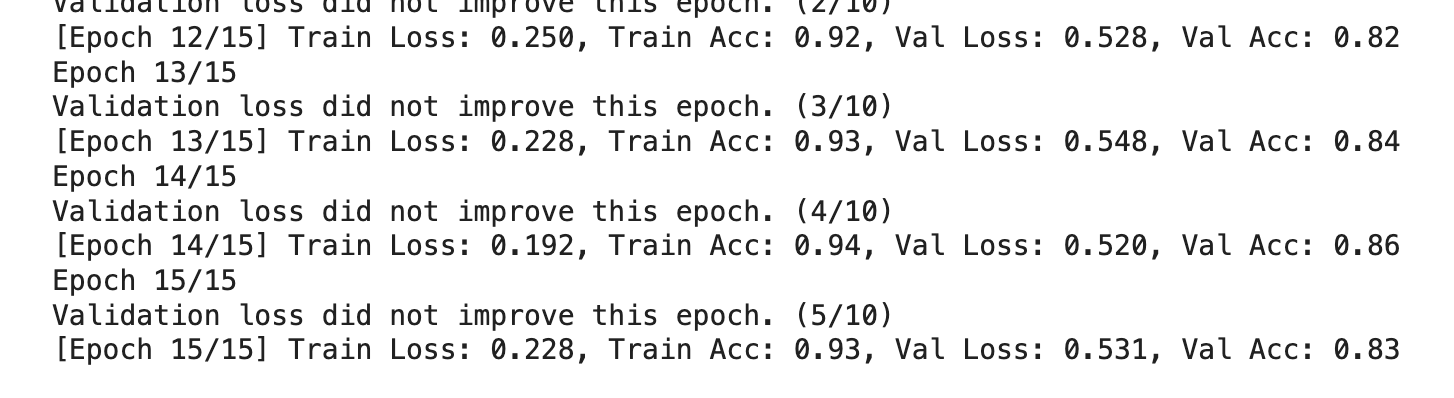

In [267]:
clf = models.efficientnet_b0(weights=None)
clf = clf.cuda() if torch.cuda.is_available() else clf
opt = torch.optim.SGD(clf.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

#### Training Model on Original Data

In [29]:
train_model(train_loader, val_loader, clf, criterion, opt, scheduler, device, n_epochs=35)

Epoch 1/35
Validation loss decreased (inf --> 6.936752). Saving the model!
[Epoch 1/35] Train Loss: 2.178, Train Acc: 0.41, Val Loss: 6.937, Val Acc: 0.36
Epoch 2/35
Validation loss decreased (6.936752 --> 2.277305). Saving the model!
[Epoch 2/35] Train Loss: 1.198, Train Acc: 0.48, Val Loss: 2.277, Val Acc: 0.44
Epoch 3/35
Validation loss decreased (2.277305 --> 1.303258). Saving the model!
[Epoch 3/35] Train Loss: 1.148, Train Acc: 0.52, Val Loss: 1.303, Val Acc: 0.51
Epoch 4/35
Validation loss did not improve this epoch. (1/5)
[Epoch 4/35] Train Loss: 1.032, Train Acc: 0.55, Val Loss: 1.555, Val Acc: 0.53
Epoch 5/35
Validation loss decreased (1.303258 --> 0.958242). Saving the model!
[Epoch 5/35] Train Loss: 0.984, Train Acc: 0.60, Val Loss: 0.958, Val Acc: 0.60
Epoch 6/35
Validation loss did not improve this epoch. (1/5)
[Epoch 6/35] Train Loss: 0.876, Train Acc: 0.65, Val Loss: 1.168, Val Acc: 0.56
Epoch 7/35
Validation loss decreased (0.958242 --> 0.909033). Saving the model!
[Ep

#### Training Model on Masked Data

In [268]:
train_model(masked_train_loader, masked_val_loader, clf, criterion, opt, scheduler, device, n_epochs=35)

Epoch 1/35
Validation loss decreased (inf --> 1.495959). Saving the model!
[Epoch 1/35] Train Loss: 2.469, Train Acc: 0.43, Val Loss: 1.496, Val Acc: 0.47
Epoch 2/35
Validation loss did not improve this epoch. (1/7)
[Epoch 2/35] Train Loss: 1.104, Train Acc: 0.52, Val Loss: 3.465, Val Acc: 0.41
Epoch 3/35
Validation loss decreased (1.495959 --> 1.046605). Saving the model!
[Epoch 3/35] Train Loss: 1.073, Train Acc: 0.54, Val Loss: 1.047, Val Acc: 0.58
Epoch 4/35
Validation loss did not improve this epoch. (1/7)
[Epoch 4/35] Train Loss: 0.981, Train Acc: 0.58, Val Loss: 1.399, Val Acc: 0.40
Epoch 5/35
Validation loss did not improve this epoch. (2/7)
[Epoch 5/35] Train Loss: 0.918, Train Acc: 0.63, Val Loss: 1.686, Val Acc: 0.45
Epoch 6/35
Validation loss did not improve this epoch. (3/7)
[Epoch 6/35] Train Loss: 0.854, Train Acc: 0.66, Val Loss: 1.093, Val Acc: 0.55
Epoch 7/35
Validation loss did not improve this epoch. (4/7)
[Epoch 7/35] Train Loss: 0.785, Train Acc: 0.68, Val Loss: 1

#### Check on test_set

In [42]:
def make_prediction(clf, test_loader, device):
    clf.eval()
    predictions = []
    test_acc = 0
    with torch.no_grad():
        for data in test_loader:
            model_input,target = data[0].to(device), data[1].to(device)
            model_output = clf(model_input)
            _, preds = torch.max(model_output, 1)

            test_acc += preds.eq(target.view_as(preds)).sum().item()
            predictions.extend(preds.cpu().numpy())
    return test_acc / len(test_loader.dataset)

acc_pred = make_prediction(clf, test_loader, device)
acc_pred

0.6624365482233503